In [1]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [114]:
lda = pd.read_csv('../../../../SFS/NDNS UK/predictions/predictions_all_LDA_v1.csv')
lda_hi = pd.read_csv('../../../../SFS/NDNS UK/predictions/predictions_all_LDA_HI_v1.csv')

<AxesSubplot:>

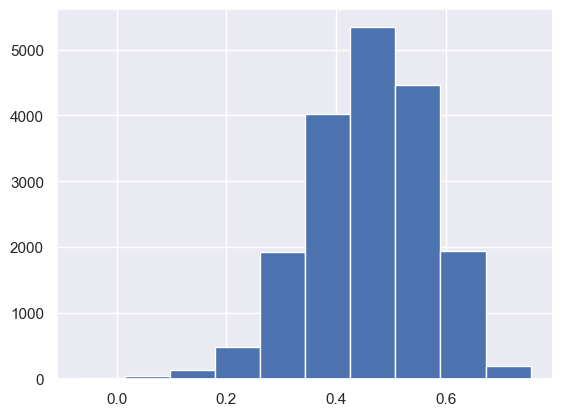

In [115]:
lda['cos_sim_lab'].hist()

<AxesSubplot:>

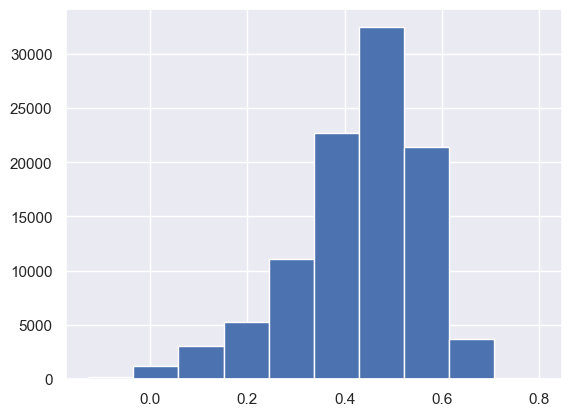

In [116]:
lda['cos_sim_pred'].hist()

<AxesSubplot:>

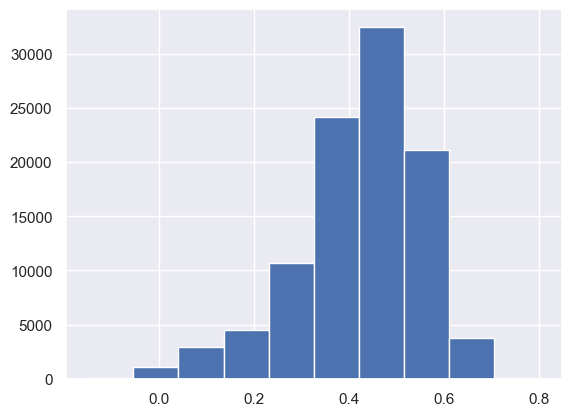

In [117]:
lda_hi['cos_sim_pred'].hist()

In [118]:
products = pd.read_csv('../../../../SFS/foodDB_23June/products.csv', usecols= [
    'product_id', 'snapshot_id', 'product_list_name', 'product_name', 'url',
    'ingredients_text', 'energy_per_100', 'fat_per_100',
    'saturates_per_100', 'salt_per_100', 'sugar_per_100',
    'carbohydrate_per_100', 'protein_per_100', 'fibre_per_100', 'serving',
    'serving_data', 'serving_value', 'serving_unit'])

products = products.drop_duplicates(['product_id']).reset_index(drop=True)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [119]:
lda = lda.merge(products[['product_id', 'ingredients_text']])
lda_hi = lda_hi.merge(products[['product_id', 'ingredients_text']])

lda['ingredients'] = 1
lda.loc[lda['ingredients_text'].isna(), 'ingredients'] = 0
lda['label'] = 1
lda.loc[lda['parentcategory_lab'].isna(), 'label'] = 0

lda_hi['ingredients'] = 1
lda_hi.loc[lda_hi['ingredients_text'].isna(), 'ingredients'] = 0
lda_hi['label'] = 1
lda_hi.loc[lda_hi['parentcategory_lab'].isna(), 'label'] = 0

ingredients
0     3489
1    15078
Name: cos_sim_pred, dtype: int64


<AxesSubplot:xlabel='cos_sim_lab', ylabel='ingredients'>

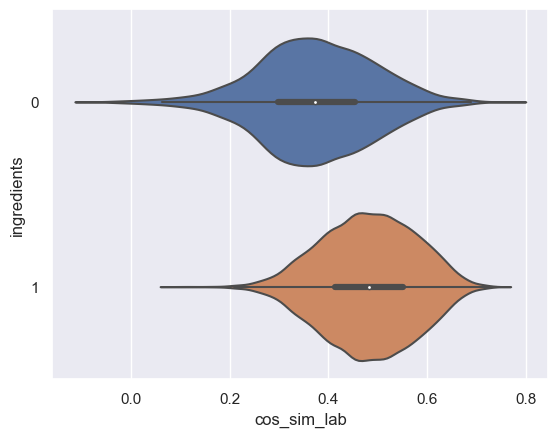

In [120]:
# ingredients lead to more similarity between product and category [labels only]
print(lda[lda["cos_sim_lab"].notnull()].groupby(['ingredients'])['cos_sim_pred'].count())
sns.violinplot(data=lda, x="cos_sim_lab", y="ingredients", orient='h')

In [121]:
lda['pred'] = lda['cos_sim_lab']
lda.loc[(lda['subfoodgroup_lab'].notnull()) & (lda['subfoodgroup_pred']!=lda['subfoodgroup_lab']), 'pred'] = 0 
lda.loc[(lda['subfoodgroup_lab'].notnull()) & (lda['subfoodgroup_pred']==lda['subfoodgroup_lab']), 'pred'] = 1

lda_hi['pred'] = lda_hi['cos_sim_lab']
lda_hi.loc[(lda_hi['subfoodgroup_lab'].notnull()) & (lda_hi['subfoodgroup_pred']!=lda_hi['subfoodgroup_lab']), 'pred'] = 0 
lda_hi.loc[(lda_hi['subfoodgroup_lab'].notnull()) & (lda_hi['subfoodgroup_pred']==lda_hi['subfoodgroup_lab']), 'pred'] = 1

In [122]:
# ingredients maybe don't really help with classification performance (within training set) [non hi model]
lda[lda['pred'].notnull()].groupby('ingredients').agg({'pred': ['count', 'mean']})

pred          
             count      mean
ingredients                 
0             3489  0.957868
1            15078  0.943361

In [123]:
# ingredients maybe don't really help with classification performance (within training set) [hi model]
lda_hi[lda_hi['pred'].notnull()].groupby('ingredients').agg({'pred': ['count', 'mean']})

pred          
             count      mean
ingredients                 
0             3489  0.938091
1            15078  0.928173

ingredients  pred
0            0.0       147
             1.0      3342
1            0.0       854
             1.0     14224
Name: cos_sim_pred, dtype: int64


<AxesSubplot:xlabel='cos_sim_pred', ylabel='ingredients'>

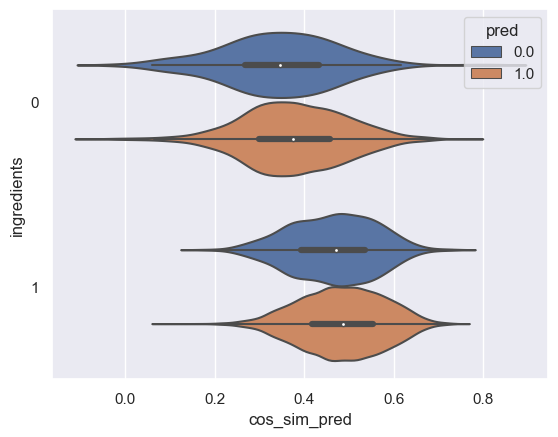

In [124]:
# within training set, correct predictions lead to slightly better matches between products and categories
# presence of ingredients leads to better matches overall
print(lda[lda["cos_sim_lab"].notnull()].groupby(['ingredients', 'pred'])['cos_sim_pred'].count())
sns.violinplot(data=lda[lda['subfoodgroup_lab'].notnull()], x="cos_sim_pred", y="ingredients", hue='pred', orient='h')

ingredients  pred
0            0.0       216
             1.0      3273
1            0.0      1083
             1.0     13995
Name: cos_sim_pred, dtype: int64


<AxesSubplot:xlabel='cos_sim_pred', ylabel='ingredients'>

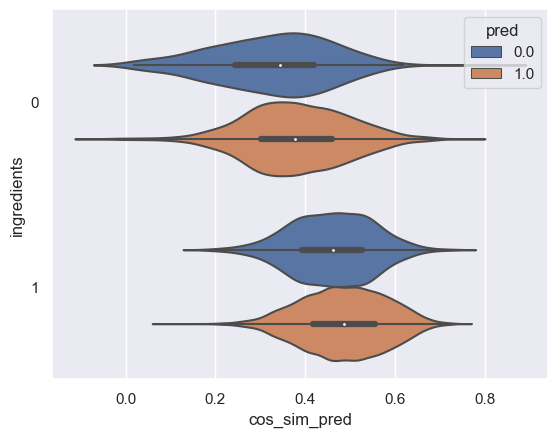

In [125]:
# within training set, correct predictions lead to slightly better matches between products and categories
# presence of ingredients leads to better matches overall
print(lda_hi[lda_hi["cos_sim_lab"].notnull()].groupby(['ingredients', 'pred'])['cos_sim_pred'].count())
sns.violinplot(data=lda_hi[lda_hi['subfoodgroup_lab'].notnull()], x="cos_sim_pred", y="ingredients", hue='pred', orient='h')

ingredients  label
0            0        19890
             1         3489
1            0        62565
             1        15078
Name: cos_sim_pred, dtype: int64


<AxesSubplot:xlabel='cos_sim_pred', ylabel='ingredients'>

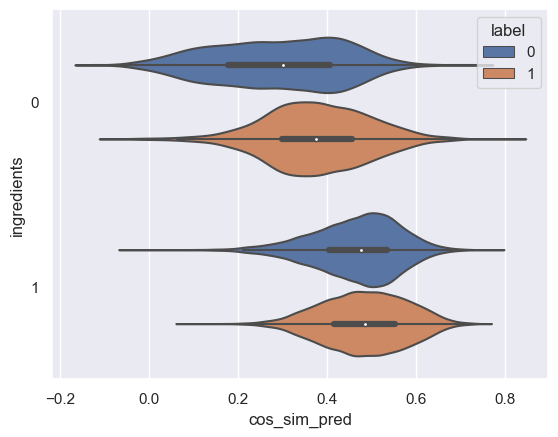

In [126]:
# overall
# presence of ingredients leads to better matches 
# predictions for products with labels have better match scores. however the difference is lower when ingredients are present 
# this could also point to some selection issue with labels
print(lda.groupby(['ingredients', 'label'])['cos_sim_pred'].count())
sns.violinplot(data=lda, x="cos_sim_pred", y="ingredients", hue='label', orient='h')

ingredients  label
0            0        19890
             1         3489
1            0        62565
             1        15078
Name: cos_sim_pred, dtype: int64


<AxesSubplot:xlabel='cos_sim_pred', ylabel='ingredients'>

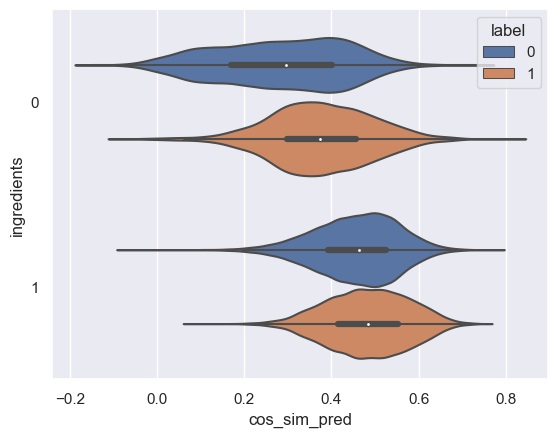

In [127]:
# overall
# presence of ingredients leads to better matches 
# predictions for products with labels have better match scores. however the difference is lower when ingredients are present
# this could also point to some selection issue with labels
print(lda_hi.groupby(['ingredients', 'label'])['cos_sim_pred'].count())
sns.violinplot(data=lda_hi, x="cos_sim_pred", y="ingredients", hue='label', orient='h')

In [188]:
# would be useful to include new labels - done
# try the different embeddings exported - done
# another modelling approach? deep learning with/without independent probabilities for all the categories? - done

# hi modelling with just level 1 and 2?
# ndb dataset from ediburgh
# trying feedback loops - maybe try a different model during feedback
# veggies lok weird in labels

# should ingredients be added when none present? - duplicate product names? take only top few ingredients when list is present?
# manual string matching for specific cases as discussed 

In [213]:
lda_f1 = pd.read_csv('../../../../SFS/NDNS UK/predictions/predictions_all_LDA_v1_f1.csv')
lda_f1 = lda.merge(products[['product_id', 'ingredients_text']])

lda_f1['ingredients'] = 1
lda_f1.loc[lda_f1['ingredients_text'].isna(), 'ingredients'] = 0
lda_f1['label'] = 1
lda_f1.loc[lda_f1['parentcategory_lab'].isna(), 'label'] = 0

lda_f1['pred'] = lda_f1['cos_sim_lab']
lda_f1.loc[(lda_f1['subfoodgroup_lab'].notnull()) & (lda_f1['subfoodgroup_pred']!=lda_f1['subfoodgroup_lab']), 'pred'] = 0 
lda_f1.loc[(lda_f1['subfoodgroup_lab'].notnull()) & (lda_f1['subfoodgroup_pred']==lda_f1['subfoodgroup_lab']), 'pred'] = 1

In [217]:
lda_f1[lda_f1['cos_sim_pred']>0.1]['label'].value_counts()

0    80021
1    18517
Name: label, dtype: int64

In [218]:
lda[lda['cos_sim_pred']>0.1]['label'].value_counts()

0    80021
1    18517
Name: label, dtype: int64

In [166]:
# lda['subfoodgroup_lab'].value_counts()

In [195]:
lda_f1[(lda_f1['cos_sim_pred']>0.6)]['subfoodgroup_pred'].value_counts()

Chocolate confectionery                                          723
Savoury sauces pickles gravies & condiments                      663
Nuts and seeds                                                   647
Other sausages (including homemade dishes)                       372
Other bacon and ham (including homemade dishes)                  341
White bread (not high fibre, not multiseed bread)                287
Crisps and savoury snacks                                        282
Meat pies and pastries                                           258
Wholemeal bread                                                  155
Sugar confectionery                                              150
Preserves                                                        129
Sweet spreads fillings and icing                                 114
Manufactured canned tuna products (including ready meals)        105
Other breakfast cereals (not high fibre)                         103
Buns cakes and pastries           

In [196]:
lda_f1[(lda_f1['cos_sim_pred']>0.6) & (lda_f1['label']==1)]['pred'].sum()

1726.0

In [198]:
lda_f1[(lda_f1['label']==1) & (lda_f1['cos_sim_pred']<0.1)].head()

,product_id,product_name,product_list_name,store,parentcategory_lab,mainfoodgroup_lab,subfoodgroup_lab,parentcategory_pred,mainfoodgroup_pred,subfoodgroup_pred,parentcategory_proba,maincategory_proba,subcategory_proba,tsne_0,tsne_1,cos_sim_pred,cos_sim_lab,ingredients_text,ingredients,label,pred
4936,11904810,Birds Eye Petit Pois 1.05Kg,Birds Eye Petit Pois 1.05Kg,tesco,"Vegetables, Potatoes",Vegetables (not raw),Peas not raw,"Vegetables, Potatoes",Vegetables (not raw),Peas not raw,0.972736,0.999994,1.0,53.157920,9.853205,0.039220,0.039220,NaN,0,1,1.0
6937,11907539,Milky Way Magic Stars 91G,Milky Way Magic Stars 91G,tesco,"Sugar, Preserves and Confectionery",Chocolate confectionery,Chocolate confectionery,Fruit,Vegetables (not raw),Chocolate confectionery,0.998874,0.986401,1.0,18.069878,42.170673,0.091782,0.091782,NaN,0,1,1.0
30016,11983839,Highland Spring Still Water 6x1.5L,Highland Spring Still Water 6x1.5L,sainsbury,Non-Alcoholic Beverages,"Tea, coffee and water",Bottled water still or carbonated,Non-Alcoholic Beverages,"Tea, coffee and water",Bottled water still or carbonated,1.000000,1.000000,1.0,50.854170,23.965351,0.095788,0.095788,NaN,0,1,1.0
30025,11983848,Highland Spring Still Water Sports Cap 12x330ml,Highland Spring Still Water Sports Cap 12x330ml,sainsbury,Non-Alcoholic Beverages,"Tea, coffee and water",Bottled water still or carbonated,Non-Alcoholic Beverages,"Tea, coffee and water",Bottled water still or carbonated,1.000000,1.000000,1.0,50.386654,22.660423,0.098309,0.098309,NaN,0,1,1.0
30096,11983919,Brita Marella Maxtra XL White Water Filter 3.5L,Brita Marella Maxtra XL White Water Filter 3.5L,sainsbury,Non-Alcoholic Beverages,"Tea, coffee and water",Bottled water still or carbonated,Non-Alcoholic Beverages,"Tea, coffee and water",Bottled water still or carbonated,1.000000,1.000000,1.0,53.459484,24.041042,0.079451,0.079451,NaN,0,1,1.0
